Now let's see what happens when there are multiple strategies.  How will this work?

If you are regularly going with your friends and it's not too crowded don't change.

Possible moves to shake things up:

1. Go based on decision k weeks ago instead of last week-- this could converge to equilibrium with alternating groups.
2. "Invite your friends"-- all go as a block once.  Then return to the regularly scheduled rule.  Let's skip this for now-- more complicated to implement.
3.  Adjust alpha, beta, epsilon.

With some small probability, mutate randomly.  If dissatisfied, you don't want to just pick from your friends' strategies because optimal strategy will depend on degree.  Maybe-- pick the best strategy from nodes with the same degree or closest degree to you.

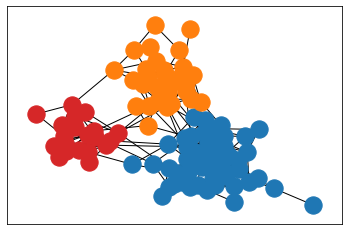

In [3]:
from matplotlib import pyplot as plt
from matplotlib import animation

import networkx as nx
import numpy as np
import numpy.ma as ma
import pandas as pd


sizes = [20, 50, 30]
probs = [[0.25,0.01, 0.01], [0.01, 0.1, 0.01], [0.01, 0.01, 1/6]]
G = nx.stochastic_block_model(sizes, probs, seed=30)
A = nx.convert_matrix.to_numpy_matrix(G)

pos = nx.spring_layout(G, seed=3113794652)
nx.draw_networkx_nodes(G, pos, nodelist=range(0,sizes[0]), node_color="tab:red")
nx.draw_networkx_nodes(G, pos, nodelist=range(sizes[0], sizes[0]+sizes[1]), node_color="tab:blue")
nx.draw_networkx_nodes(G, pos, nodelist=range(sizes[0]+sizes[1], 100), node_color="tab:orange")
nx.draw_networkx_edges(G, pos)

In [88]:
rng = np.random.default_rng(98765)

# track all the different parameters at each timestep.
N = 100
M = 60
n_trials = 1000
memory_length = 5


# minimum number of friends who went last time if it wasn't full
alphas = np.ones((N, n_trials), dtype=int) * 2 
# minimum number of friends who went last time if it was too full
betas = np.ones((N, n_trials), dtype=int) * 5
# weeks back to look when making decision
gammas = np.ones((N, n_trials), dtype=int) * -1
# random probability of going
epsilons = np.ones((N, n_trials)) * 0.03
# random probability of not going
# nonzero delta could completely destabilize an arrangement
# I think?
deltas = np.zeros((N, n_trials)) 

# each node needs to remember the last k weeks
# options- we could target interventions to particular 
# circumstances, e.g. reduce minfriends if you are never going
# or we could just let things evolve randomly
# let's start with random because yolo
memory = np.full((N, memory_length), np.nan)

# initial conditions
Xnp = np.full((N, n_trials), np.nan)
X = rng.uniform(size=(100,)) < 0.3
Xnp[:,0] = X

# track previous weeks' neighbor counts to avoid
# redoing multiplication
nc = np.full((N, n_trials), np.nan)

In [137]:
def apply_thresholds(params, t, X, nc):
    for p in np.unique(params[:, t]):
        mask = np.where(params[:,t] == p)
        X[mask] = nc[mask, t] > p
        

# start by just running the first round of the simulation
t = 0

# number of neighbors that went last week
nc[:,t] = A.dot(X)


if X.sum() < M:
    apply_thresholds(alphas, t, X, nc)
else:
    apply_thresholds(betas, t, X, nc)
    
# add noise
X += rng.uniform(size=N) > epsilons[:,t]
X = np.bitwise_xor(X, rng.uniform(size=N) > deltas[:,t])

t += 1
Xnp[:,0] = X

In [138]:
deltas[:,t]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [132]:
epsilons[:,t]

array([0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03])

In [135]:
(rng.uniform(size=N) > epsilons[:,t])

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [83]:
params = alphas

for p in np.unique(params[:, t]):
    print(p)

2


In [58]:
alphas = np.ones((N, n_trials), dtype=int) * 2 
alphas[50:, :] = 3

print(X)
print("\n")

# number of neighbors that went last week
nc[:,t] = A.dot(X)
apply_thresholds(alphas, t, X, nc)
print(X)

array([False, False, False, False, False,  True, False, False,  True,
       False,  True, False, False, False,  True, False, False, False,
       False, False, False, False,  True,  True, False, False,  True,
       False, False, False,  True,  True, False,  True, False,  True,
       False, False, False,  True,  True,  True, False, False, False,
       False, False, False, False, False, False,  True, False, False,
        True, False, False, False, False, False,  True, False,  True,
       False, False, False,  True, False,  True, False, False,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False,  True, False,
        True,  True, False, False,  True,  True, False, False, False,
       False])

In [1]:
def run_sim(n_iter, X, eps, M, minfriends, minbad):
    Xs = [X]
    for _ in range(n_iter):
        if X.sum() < M:
            # go if enough of your friends went last week
            # whether or not you went
            X = (A.dot(X) > minfriends)
        else:
            X = (A.dot(X) > minbad)
            
        # this is okay because X is an array of booleans
        X += rng.uniform(size=(100,1)) < eps
        Xs.append(X)

    return np.hstack(Xs)